In [1]:
import pathlib
import tarfile

from astropy.utils.data import download_file
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
url = "http://data.astropy.org/tutorials/UVES/data_UVES.tar.gz"
f = tarfile.open(download_file(url, cache=True), mode="r|*")
working_dir_path = pathlib.Path("~/.astropy/cache/download").expanduser()
f.extractall(path=working_dir_path)

In [3]:
import os

import numpy as np

from astropy.wcs import WCS
from astropy.io import fits

# os.path.join is a platform-independent way to join two directories
globpath = working_dir_path / "UVES"

print(globpath)

# glob searches through directories similar to the Unix shell
filelist = list(globpath.glob("*.fits"))

# sort alphabetically - also sorts in time due to style of filename
filelist.sort()

C:\Users\Soham Das\.astropy\cache\download\UVES


In [4]:
def read_spec(filename):
    """Read a UVES spectrum from the ESO pipeline

    Parameters
    ----------
    filename : string
    name of the fits file with the data

    Returns
    -------
    wavelength : np.ndarray
    wavelength (in Ang)
    flux : np.ndarray
    flux (in erg/s/cm**2)
    date_obs : string
    time of observation
    """
    sp = fits.open(filename)
    header = sp[0].header

    wcs = WCS(header)
    # make index array
    index = np.arange(header["NAXIS1"])

    wavelength = wcs.wcs_pix2world(index[:, np.newaxis], 0)
    wavelength = wavelength.flatten()
    flux = sp[0].data

    date_obs = header["Date-OBS"]
    return wavelength, flux, date_obs, header

In [5]:
help(read_spec)

Help on function read_spec in module __main__:

read_spec(filename)
    Read a UVES spectrum from the ESO pipeline

    Parameters
    ----------
    filename : string
    name of the fits file with the data

    Returns
    -------
    wavelength : np.ndarray
    wavelength (in Ang)
    flux : np.ndarray
    flux (in erg/s/cm**2)
    date_obs : string
    time of observation



In [6]:
def read_setup(filename):
    """Get setup for UVES spectrum from the ESO pipeline

    Parameters
    ----------
    filename : string
    name of the fits file with the data

    Returns
    -------
    exposure_time : float
    wavelength_zero_point : float
    optical_arm : string
    """
    sp = fits.open(filename)
    header = sp[0].header

    return header["EXPTIME"], header["CRVAL1"], header["HIERARCH ESO INS PATH"]

for f in filelist:
    print(read_setup(f))

(1200.0013, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0011, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.001, 3732.05623191818, 'BLUE')
(1200.001, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0011, 3732.05623191818, 'BLUE')
(1200.0011, 3732.05623191818, 'BLUE')
(1200.0011, 3732.05623191818, 'BLUE')
(1200.0012, 3732.05623191818, 'BLUE')
(1200.0011, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')


In [7]:
wavelength, f_, d_, h_ = read_spec(filelist[0])
flux = np.zeros((len(filelist), len(wavelength)))
# date comes as string with 23 characters (dtype = 'S23')
date = np.zeros((len(filelist)), dtype="U23")

for i, fname in enumerate(filelist):
    w, f, date_obs, h_ = read_spec(fname)
    flux[i, :] = f
    date[i] = date_obs

In [8]:
import astropy.units as u
from astropy.constants import c, G, M_sun, R_sun

wavelength = wavelength * u.AA
print(wavelength)

heliocentric = -23.0 * u.km / u.s
v_rad = -4.77 * u.km / u.s  # Strassmeier et al. (2005)
R_MN_Lup = 0.9 * R_sun  # Strassmeier et al. (2005)
M_MN_Lup = 0.6 * M_sun  # Strassmeier et al. (2005)
vsini = 74.6 * u.km / u.s  # Strassmeier et al. (2005)
period = 0.439 * u.day  # Strassmeier et al. (2005)

inclination = 45.0 * u.degree  # Strassmeier et al. (2005)

incl = inclination.to(u.radian)

[3732.05623192 3732.0858853  3732.11553869 ... 4999.67906915 4999.70872253
 4999.73837591] Angstrom


In [9]:
from astropy.units import imperial

v_accr = (2.0 * G * M_MN_Lup / R_MN_Lup) ** 0.5
print(v_accr)
print(v_accr.cgs)
print(v_accr.to(imperial.yd / u.hour))

504329.2809002659 m / s
50432928.09002659 cm / s
1985548350.0010464 yd / h


In [10]:
v_rot = vsini / np.sin(incl)
print(v_accr / v_rot)
print((v_accr / v_rot).decompose())

4780.357298599373 m / km
4.780357298599373


In [11]:
print(wavelength)
wavelength = wavelength * (1.0 * u.dimensionless_unscaled + heliocentric / c)
print(wavelength)

[3732.05623192 3732.0858853  3732.11553869 ... 4999.67906915 4999.70872253
 4999.73837591] Angstrom
[3731.76990953 3731.79956064 3731.82921174 ... 4999.29549506 4999.32514617
 4999.35479727] Angstrom


In [12]:
wavelength.to(u.keV, equivalencies=u.spectral())
wavelength.to(u.Hz, equivalencies=u.spectral())

<Quantity [8.03351936e+14, 8.03345553e+14, 8.03339170e+14, ...,
           5.99669410e+14, 5.99665853e+14, 5.99662297e+14] Hz>

In [13]:
print(np.log10((G * M_MN_Lup / R_MN_Lup**2) / u.cm * u.second**2))

4.3077338588081275


In [14]:
waveclosetoHa = np.array([6562.0, 6563, 6565.0]) * u.AA

In [15]:
# This function uses the Doppler equivalency between wavelength and velocity
import astropy.units as u


def wave2doppler(w, w0):
    w0_equiv = u.doppler_optical(w0)
    w_equiv = w.to(u.km / u.s, equivalencies=w0_equiv)
    return w_equiv


print(wave2doppler(waveclosetoHa, 656.489 * u.nm).to(u.km / u.s))

[-131.9748242   -86.30879506    5.0232632 ] km / s


In [16]:
def w2vsini(w, w0):
    v = wave2doppler(w, w0) - 4.77 * u.km / u.s
    return v / vsini

In [18]:
from astropy.time import Time

header = h_
t1 = Time(header["MJD-Obs"], format="mjd", scale="utc")
t2 = Time(header["Date-Obs"], scale="utc")

In [23]:
obs_times = Time(date, scale="utc")
delta_t = obs_times - Time(date[0], scale="utc")
delta_p = delta_t.value * u.day / period

In [19]:
def region_around_line(w, flux, cont):
    """cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
    array of wavelengths
    flux : np.ndarray of shape (N, len(w))
    array of flux values for different spectra in the series
    cont : list of lists
    wavelengths for continuum normalization [[low1,up1],[low2, up2]]
    that described two areas on both sides of the line
    """
    # index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) | (
        (w > cont[1][0]) & (w < cont[1][1])
    )
    # index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    # make a flux array of shape (number of spectra, number of points in indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynomial of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], 2)
        # divide the flux by polynomial and put result in new flux array
        f[i, :] = flux[i, indrange] / np.polyval(linecoeff, w[indrange].value)
    return w[indrange], f


wcaII, fcaII = region_around_line(
    wavelength, flux, [[3925 * u.AA, 3930 * u.AA], [3938 * u.AA, 3945 * u.AA]]
)

In [20]:
ew = fcaII[0, :] - 1.0
ew = ew[:-1] * np.diff(wcaII.to(u.AA).value)
print(ew.sum())

19.377607144111902


In [21]:
delta_lam = np.diff(wcaII.to(u.AA).value)
ew = np.sum((fcaII - 1.0)[:, :-1] * delta_lam[np.newaxis, :], axis=1)

In [24]:
from astropy.table import Column, Table
from astropy.io import ascii

datecol = Column(name="Obs Date", data=date)
pcol = Column(name="phase", data=delta_p, format="{:.1f}")
ewcol = Column(name="EW", data=ew, format="{:.1f}", unit="\\AA")
tab = Table((datecol, pcol, ewcol))
# latexdicts['AA'] contains the style specifics for A&A (\hline etc.)
tab.write(
    os.path.join(working_dir_path, "EWtab.tex"),
    latexdict=ascii.latexdicts["AA"],
    overwrite=True,
)

In [25]:
x = w2vsini(wcaII, 393.366 * u.nm).decompose()

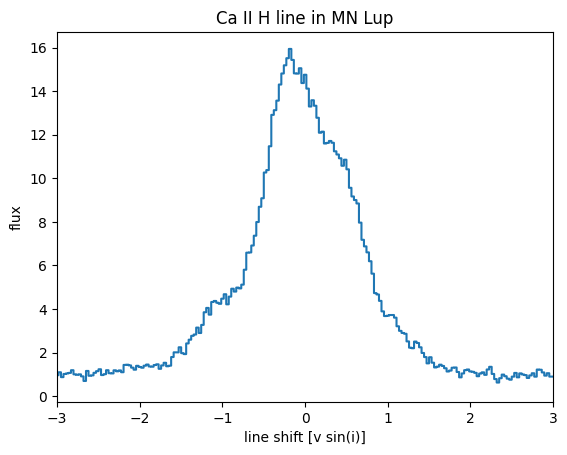

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, fcaII[0, :], marker="", drawstyle="steps-mid")
ax.set_xlim([-3, +3])
ax.set_xlabel("line shift [v sin(i)]")
ax.set_ylabel("flux")
ax.set_title("Ca II H line in MN Lup")
plt.draw()

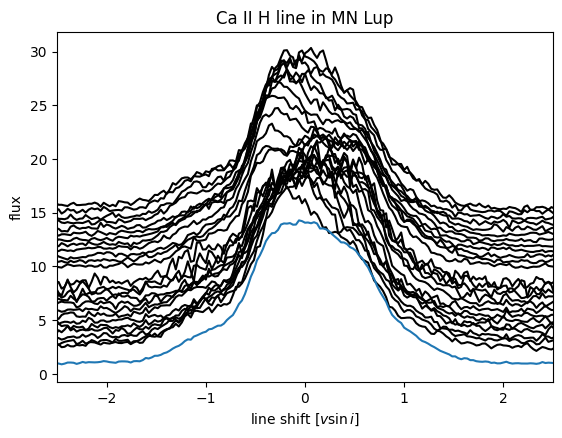

In [27]:
yshift = np.arange((fcaII.shape[0])) * 0.5
# shift the second night up by a little
yshift[:] += 1.5
yshift[13:] += 1

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(25):
    ax.plot(x, fcaII[i, :] + yshift[i], "k")

# separately show the mean line profile in a different color
ax.plot(x, np.mean(fcaII, axis=0))
ax.set_xlim([-2.5, +2.5])
ax.set_xlabel("line shift [$v \\sin i$]")
ax.set_ylabel("flux")
ax.set_title("Ca II H line in MN Lup")
fig.subplots_adjust(bottom=0.15)
plt.draw()

In [28]:
fmean = np.mean(fcaII, axis=0)
fdiff = fcaII - fmean[np.newaxis, :]

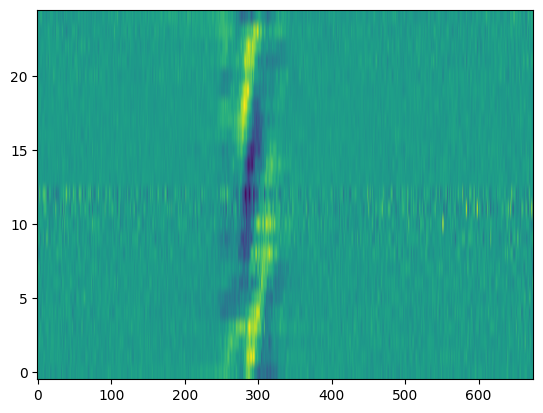

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(fdiff, aspect="auto", origin="lower")

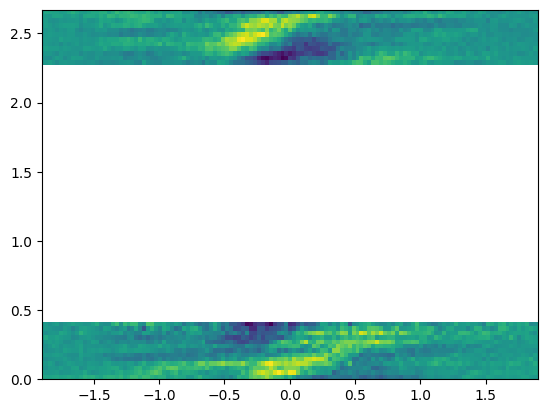

In [30]:
ind1 = delta_p < 1 * u.dimensionless_unscaled
ind2 = delta_p > 1 * u.dimensionless_unscaled

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for ind in [ind1, ind2]:
    im = ax.imshow(
        fdiff[ind, :],
        extent=(np.min(x), np.max(x), np.min(delta_p[ind]), np.max(delta_p[ind])),
        aspect="auto",
        origin="lower",
    )

ax.set_ylim([np.min(delta_p), np.max(delta_p)])
ax.set_xlim([-1.9, 1.9])
plt.draw()

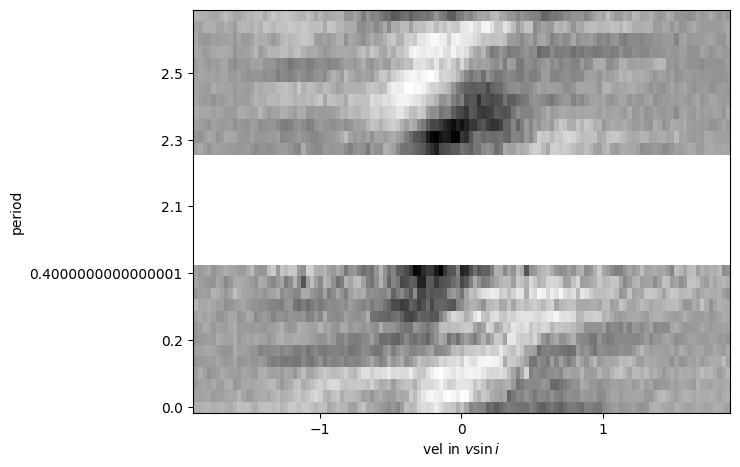

In [31]:
# shift a little for plotting purposes
pplot = delta_p.copy().value
pplot[ind2] -= 1.5
# image goes from x1 to x2, but x1 should be middle of first pixel
delta_t = np.median(np.diff(delta_p)) / 2.0
delta_x = np.median(np.diff(x)) / 2.0
# imshow does the normalization for plotting really well, but did manually to ensure it goes -1,+1
fdiff = fdiff / np.max(np.abs(fdiff))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for ind in [ind1, ind2]:
    im = ax.imshow(
        fdiff[ind, :],
        extent=(
            np.min(x) - delta_x,
            np.max(x) + delta_x,
            np.min(pplot[ind]) - delta_t,
            np.max(pplot[ind]) + delta_t,
        ),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.Greys_r,
    )

ax.set_ylim([np.min(pplot) - delta_t, np.max(pplot) + delta_t])
ax.set_xlim([-1.9, 1.9])
ax.set_xlabel("vel in $v\\sin i$")
ax.xaxis.set_major_locator(plt.MaxNLocator(4))


def pplot(y, pos):
    "The two args are the value and tick position"
    "Function to make tick labels look good."
    if y < 0.5:
        yreal = y
    else:
        yreal = y + 1.5
    return yreal


formatter = plt.FuncFormatter(pplot)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("period")
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.99, top=0.99)
plt.draw()